In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")

print("Path to dataset files:", path)

/home/reshni/py3_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/reshni/.cache/kagglehub/datasets/ashishjangra27/face-mask-12k-images-dataset/versions/1


In [69]:
path

'/home/reshni/.cache/kagglehub/datasets/ashishjangra27/face-mask-12k-images-dataset/versions/1'

In [70]:
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
load=ImageDataGenerator()
train = load.flow_from_directory(path + '/Face Mask Dataset/Train',target_size=(100,100))
test = load.flow_from_directory(path + '/Face Mask Dataset/Test', target_size=(100,100))
validation = load.flow_from_directory(path + '/Face Mask Dataset/Validation',target_size=(100,100))

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [71]:
# Retrieve class indices and sort them by index to get the correct label order
labels = [label for label, index in sorted(train.class_indices.items(), key=lambda x: x[1])]

print("Class labels as detected by ImageDataGenerator:", labels)

Class labels as detected by ImageDataGenerator: ['WithMask', 'WithoutMask']


# TRAINING

In [72]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
batch_size=32
# Update your checkpoint to use 'val_accuracy'
checkpoint = ModelCheckpoint("mask_detector.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

# Update early stopping to monitor 'val_accuracy' with mode='max'
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='max')

# Ensure your steps_per_epoch and validation_steps are set appropriately
epoch = len(train) // batch_size  # Adjust based on your data
validation_steps = len(test) // batch_size   # Adjust based on your data


In [76]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
model = Sequential()

model.add(Conv2D(32, (3,3),input_shape=(100,100,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,290,946 (4.92 MB)

 Trainable params: 1,290,946 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
result = model.fit(
    train,
    steps_per_epoch=epoch,
    epochs=100,
    validation_data=validation,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early]
)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4961 - loss: 14.9979
Epoch 1: val_accuracy improved from -inf to 0.76125, saving model to mask_detector.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.5069 - loss: 14.3724 - val_accuracy: 0.7613 - val_loss: 0.6863
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9016 - loss: 0.3590
Epoch 2: val_accuracy improved from 0.76125 to 0.88250, saving model to mask_detector.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.9017 - loss: 0.3573 - val_accuracy: 0.8825 - val_loss: 0.3166
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9180 - loss: 0.3034
Epoch 3: val_accuracy improved from 0.88250 to 0.93500, saving model to mask_detector.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9175 - loss: 0.2994 - val_accuracy: 0.9350 - val_loss: 0.1758
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9421 - loss: 0.1714
Epoch 4: val_accuracy improved from 0.93500 

2024-11-08 22:39:05.745422: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 35: val_accuracy did not improve from 0.99250
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.9784 - loss: 0.0901 - val_accuracy: 0.9787 - val_loss: 0.0463
Epoch 36/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9826 - loss: 0.0599
Epoch 36: val_accuracy did not improve from 0.99250
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.9823 - loss: 0.0601 - val_accuracy: 0.9712 - val_loss: 0.0755
Epoch 37/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9739 - loss: 0.0901
Epoch 37: val_accuracy did not improve from 0.99250
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - accuracy: 0.9741 - loss: 0.0885 - val_accuracy: 0.9762 - val_loss: 0.0645
Epoch 38/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9657 - loss: 0.1001
Epoch 38: val_accuracy did not improve from 0.99250
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 0.9670 - loss: 0.0958 - val_accuracy: 0.9675 - val_loss: 0.0825
Epoch 39/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9719 - 

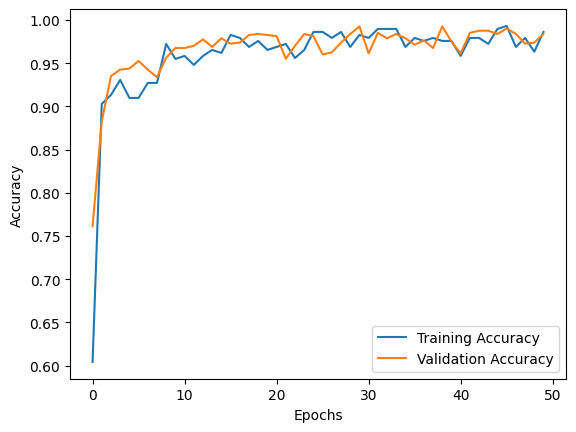

In [78]:
import matplotlib.pyplot as plt

plt.plot(result.history['accuracy'], label='Training Accuracy')
plt.plot(result.history['val_accuracy'], label='Validation Accuracy')  # Use 'val_accuracy' here
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


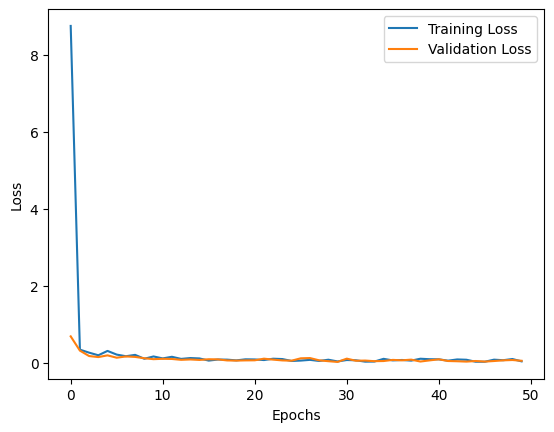

In [79]:
plt.plot(result.history['loss'], label='Training Loss')
plt.plot(result.history['val_loss'], label='Validation Loss')  # Use 'val_loss' here
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [97]:
from tensorflow.keras.models import load_model

model_ = load_model('mask_detector.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


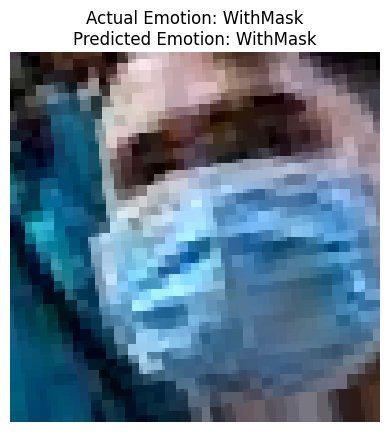

In [95]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

mask_labels = [label for label, index in sorted(train.class_indices.items(), key=lambda x: x[1])]

# Function to test and display image with actual and predicted emotion
def test_and_display_image(model, testdata, index=0):
    # Ensure index is within the bounds of the current batch
    try:
        test_images, test_labels = next(testdata)
        img = test_images[index]
        true_label = np.argmax(test_labels[index])  # Get the actual emotion label index
        true_mask = mask_labels[true_label]

        # Prepare the image for prediction
        input_img = np.expand_dims(img, axis=0)
        
        # Get predictions from the model
        predictions = model.predict(input_img)
        predicted_index = np.argmax(predictions[0])
        predicted_mask = mask_labels[predicted_index]
        
        # Normalize the image to the valid range for display
        if img.max() > 1.0:  # If values are in the range [0, 255]
            img = img / 255.0  # Normalize to [0, 1] for imshow

        # Check if the image is grayscale or RGB
        if img.shape[-1] == 1:  # Grayscale
            plt.imshow(img.squeeze(), cmap='gray')
        else:  # RGB
            plt.imshow(img)
        
        # Display the title with actual and predicted emotions
        plt.title(f"Actual Emotion: {true_mask}\nPredicted Emotion: {predicted_mask}")
        plt.axis('off')
        plt.show()

    except IndexError:
        print(f"Index {index} is out of bounds for the current batch of size {test_images.shape[0]}")


# Run the function with your model and testdata
test_and_display_image(model_, test, index=30)  # Change index to test different images 0-31


In [99]:
mask_labels

['WithMask', 'WithoutMask']